<a href="https://colab.research.google.com/github/PedroLuizPG/Processamento-de-Imagens_E01_Grupo3/blob/main/Projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processando imagens...


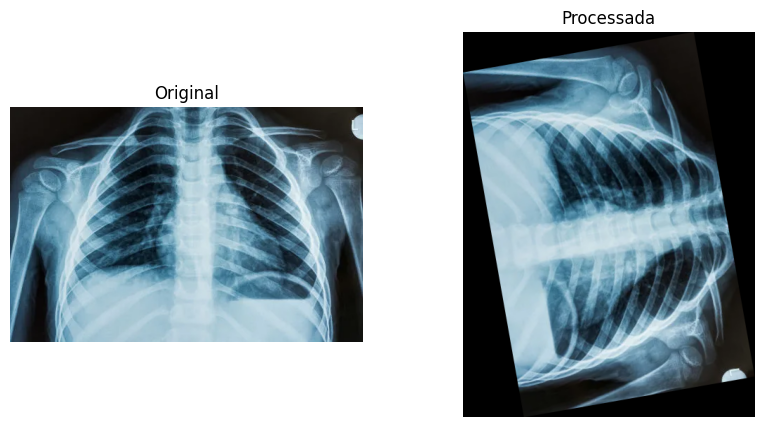

,arquivo_original,arquivo_processado,modo,auto_align,gerou_thumbs,largura_alvo,altura_alvo,angulo_rotacao,qualidade,tempo_exec,data
0,raioX (1).png,proc_raioX (1).png,Ambos,False,False,auto,auto,280,55,0.041,2025-11-12 01:38:35



 Avaliação de redimensionamento em múltiplas resoluções:


,resolução,perda_qualidade(%),nitidez
0,128x128,43.19,3343.73
1,256x256,30.76,1208.07
2,512x512,14.84,227.94
3,1024x1024,0.00,26.24
4,1920x1080,0.00,6.44



 Comparação de qualidade entre imagem original e processada:
Perda de qualidade estimada: 83.04%

 Análise do efeito da rotação sobre a nitidez:


,ângulo,nitidez,perda_nitidez(%)
0,0,295.66,0.00
1,15,204.10,30.97
2,30,193.36,34.60
3,45,202.79,31.41
4,60,193.67,34.50
5,90,288.26,2.50


Button(button_style='info', description='Baixar ZIP', style=ButtonStyle())

In [ ]:
from skimage.transform import rotate
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from datetime import datetime
from IPython.display import display, clear_output, Markdown
from PIL import Image
import pandas as pd
from google.colab import files
import zipfile
import ipywidgets as widgets

PASTA_SAIDA = "imagens_processadas"
os.makedirs(PASTA_SAIDA, exist_ok=True)

historico = []
imagens = []

doc_md = """
# Módulo: Redimensionamento / Rotação / Auto-align / Miniaturas

**O que este notebook fornece (resumo):**
- Upload de imagens pelo Colab.
- Pré-visualização em tempo real das transformações.
- Redimensionamento manual/automático (preserva proporção).
- Rotação manual (ângulo) e rotação automática (estimativa via HoughLinesP).
- Recorte automático usando detecção de contornos (ROI).
- `auto_align`: recorte + correção de inclinação (pipeline automático).
- Geração automática de miniaturas (vários tamanhos) e salvamento.
- Histórico e exportação ZIP dos resultados.

Use a interface abaixo para carregar suas imagens, ajustar parâmetros e confirmar o processamento.
"""
display(Markdown(doc_md))

def upload_imagens_colab():
    """Upload de imagens no Colab e retorna lista de (caminho, imagem)."""
    uploaded = files.upload()
    imgs = []
    for nome in uploaded.keys():
        caminho = nome
        img = cv2.imread(caminho)
        if img is not None:
            imgs.append((caminho, img))
        else:
            print(f"Erro ao carregar {caminho}")
    return imgs

def validar_imagem(img):
    return img is not None and img.shape[0] > 10 and img.shape[1] > 10

def redimensionar_imagem(img, largura_alvo=None, altura_alvo=None):
    """Redimensiona mantendo proporção aproximada."""
    h, w = img.shape[:2]
    if largura_alvo and altura_alvo:
        proporcao = min(largura_alvo / w, altura_alvo / h)
        novo_w = int(w * proporcao)
        novo_h = int(h * proporcao)
    elif largura_alvo:
        proporcao = largura_alvo / w
        novo_w = largura_alvo
        novo_h = int(h * proporcao)
    elif altura_alvo:
        proporcao = altura_alvo / h
        novo_w = int(w * proporcao)
        novo_h = altura_alvo
    else:
        return img
    return cv2.resize(img, (novo_w, novo_h), interpolation=cv2.INTER_CUBIC)

def redimensionar_automatico(img, largura_max=800, altura_max=800):
    """Redimensiona automaticamente mantendo proporção."""
    h, w = img.shape[:2]
    proporcao = min(largura_max / w, altura_max / h, 1.0)
    novo_w, novo_h = int(w * proporcao), int(h * proporcao)
    return cv2.resize(img, (novo_w, novo_h), interpolation=cv2.INTER_CUBIC)

def rotacionar_imagem(img, angulo=0):
    """Rotação manual (skimage.rotate) preservando range."""
    if img is None:
        return img
    return rotate(img, angle=angulo, resize=True, preserve_range=True).astype(np.uint8)

def rotacao_automatica(img, debug=False):
    """
    Detecta o ângulo dominante com HoughLinesP (linhas detectadas nas bordas)
    e corrige a inclinação.
    Retorna a imagem rotacionada. Se não houver linhas suficientes, retorna original.
    """
    if img is None:
        return img

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img.copy()
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 50, 150, apertureSize=3)

    linhasP = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=50, minLineLength=30, maxLineGap=10)
    if linhasP is None:
        if debug: print("rotacao_automatica: sem linhas detectadas")
        return img

    angulos = []
    for l in linhasP:
        x1, y1, x2, y2 = l[0]
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0:
            continue
        ang = np.degrees(np.arctan2(dy, dx))
        if abs(ang) < 45:
            angulos.append(ang)

    if not angulos:
        if debug: print("rotacao_automatica: sem ângulos úteis")
        return img

    ang_mediana = np.median(angulos)
    if debug:
        print(f"rotacao_automatica: angulos detectados (mediana) = {ang_mediana:.2f} deg")

    img_corrigida = rotacionar_imagem(img, -ang_mediana)
    return img_corrigida

def recorte_automatico(img, padding=5):
    """
    Detecta a maior ROI por contornos após threshold adaptativo e retorna o recorte.
    Se não encontrar contornos relevantes, retorna a imagem original.
    """
    if img is None:
        return img
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img.copy()
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    clean = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

    contornos, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contornos:
        return img

    maior = max(contornos, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(maior)

    x0 = max(x - padding, 0)
    y0 = max(y - padding, 0)
    x1 = min(x + w + padding, img.shape[1])
    y1 = min(y + h + padding, img.shape[0])

    return img[y0:y1, x0:x1]

def auto_align(img, debug=False):
    """
    Pipeline automático: recorte por ROI -> detecção de inclinação -> correção.
    Retorna imagem recortada e alinhada.
    """
    if img is None:
        return img
    rec = recorte_automatico(img)
    rot = rotacao_automatica(rec, debug=debug)
    return rot


def gerar_miniaturas(img, tamanhos=[(64,64), (128,128), (256,256)], prefix="thumb"):
    """
    Gera miniaturas (thumbnails) com interpolação AREA (boa para redução),
    salva em PASTA_SAIDA e retorna lista de caminhos salvos.
    """
    thumbs_paths = []
    for w, h in tamanhos:
        thumb = cv2.resize(img, (w,h), interpolation=cv2.INTER_AREA)
        nome = f"{prefix}_{w}x{h}.jpg"
        caminho = os.path.join(PASTA_SAIDA, nome)
        cv2.imwrite(caminho, thumb, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
        thumbs_paths.append(caminho)
    return thumbs_paths

def comparar_imagens(img1, img2, titulo1="Original", titulo2="Processada"):
    plt.figure(figsize=(10,5))
    for i, (im, title) in enumerate(zip([img1, img2], [titulo1, titulo2]), 1):
        plt.subplot(1,2,i)
        if im is None:
            plt.text(0.5, 0.5, "Imagem vazia", ha='center')
            continue
        if len(im.shape) == 3:
            plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(im, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

def calcular_perda_qualidade(img_original, img_processada):
    """
    Calcula a perda percentual de qualidade entre a imagem original e processada
    com base no PSNR (Peak Signal-to-Noise Ratio).
    Retorna a perda percentual estimada.
    """
    if img_original is None or img_processada is None:
        return None

    if img_original.shape != img_processada.shape:
        img_processada = cv2.resize(img_processada, (img_original.shape[1], img_original.shape[0]))

    mse = np.mean((img_original.astype("float") - img_processada.astype("float")) ** 2)
    if mse == 0:
        return 0.0

    psnr = 20 * np.log10(255.0 / np.sqrt(mse))
    perda = max(0, min(100, (50 - psnr) / 50 * 100))
    return round(perda, 2)


def calcular_nitidez(img):
    """
    Mede a nitidez de uma imagem usando a variância do Laplaciano.
    Quanto maior o valor, mais nítida a imagem.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
    return cv2.Laplacian(gray, cv2.CV_64F).var()


def avaliar_rotacao_nitidez(img, angulos=[0, 15, 30, 45, 60, 90]):
    """
    Aplica rotações em diferentes ângulos e avalia a variação de nitidez.
    Retorna um DataFrame com os resultados.
    """
    resultados = []
    nitidez_base = calcular_nitidez(img)
    for ang in angulos:
        img_rot = rotacionar_imagem(img, ang)
        nitidez_rot = calcular_nitidez(img_rot)
        perda_nitidez = round(((nitidez_base - nitidez_rot) / nitidez_base) * 100, 2) if nitidez_base != 0 else 0
        resultados.append({
            "ângulo": ang,
            "nitidez": round(nitidez_rot, 2),
            "perda_nitidez(%)": perda_nitidez
        })
    return pd.DataFrame(resultados)


def testar_redimensionamento_multiescala(img):
    """
    Testa redimensionamento em diferentes escalas (baixa e alta resolução)
    e avalia qualidade e nitidez em cada caso.
    """
    tamanhos = [(128,128), (256,256), (512,512), (1024,1024), (1920,1080)]
    resultados = []
    for w,h in tamanhos:
        redim = redimensionar_imagem(img, largura_alvo=w, altura_alvo=h)
        perda_q = calcular_perda_qualidade(img, redim)
        nitidez = calcular_nitidez(redim)
        resultados.append({
            "resolução": f"{w}x{h}",
            "perda_qualidade(%)": perda_q,
            "nitidez": round(nitidez,2)
        })
    return pd.DataFrame(resultados)

def salvar_imagem(img, nome_arquivo, qualidade=95):
  caminho = os.path.join(PASTA_SAIDA, nome_arquivo)
  if nome_arquivo.lower().endswith((".jpg", ".jpeg")):
      cv2.imwrite(caminho, img, [int(cv2.IMWRITE_JPEG_QUALITY), qualidade])
  else:
      cv2.imwrite(caminho, img)
  return caminho

def aplicar_transformacoes(img, largura=None, altura=None, angulo=0, qualidade=95,
                           auto_resize=False, modo="Ambos", auto_align_flag=False, gerar_thumbs=False):
    """
    Aplica redimensionamento/rotacao; se auto_align_flag True executa auto_align;
    se gerar_thumbs True gera miniaturas (salvas em PASTA_SAIDA).
    """
    img_proc = img.copy()
    if auto_align_flag:
        img_proc = auto_align(img_proc)
    else:
        if auto_resize:
            img_proc = redimensionar_automatico(img_proc)
        else:
            if modo in ["Redimensionar", "Ambos"]:
                img_proc = redimensionar_imagem(img_proc, largura, altura)
        if modo in ["Rotacionar", "Ambos"]:
            img_proc = rotacionar_imagem(img_proc, angulo)

    thumbs = []
    if gerar_thumbs:
        thumbs = gerar_miniaturas(img_proc, prefix=f"thumb_{os.path.splitext(os.path.basename('img'))[0]}")
    return img_proc, thumbs

def processar_lote(lista_imagens, largura=None, altura=None, angulo=0, qualidade=95,
                   auto_resize=False, modo="Ambos", auto_align_flag=False, gerar_thumbs=False):
    """Processa lote de imagens e salva resultados; retorna lista de (orig, proc, thumbs)."""
    resultados = []
    for caminho, img in lista_imagens:
        inicio = time.time()
        if not validar_imagem(img):
            print(f"Imagem inválida: {caminho}")
            continue

        img_proc, thumbs = aplicar_transformacoes(img, largura, altura, angulo, qualidade,
                                                  auto_resize, modo, auto_align_flag, gerar_thumbs)

        nome_arquivo = f"proc_{os.path.basename(caminho)}"
        salvar_imagem(img_proc, nome_arquivo, qualidade)

        fim = time.time()
        historico.append({
            "arquivo_original": caminho,
            "arquivo_processado": nome_arquivo,
            "modo": modo,
            "auto_align": auto_align_flag,
            "gerou_thumbs": bool(thumbs),
            "largura_alvo": largura if not auto_resize else "auto",
            "altura_alvo": altura if not auto_resize else "auto",
            "angulo_rotacao": angulo,
            "qualidade": qualidade,
            "tempo_exec": round(fim - inicio,3),
            "data": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        })
        resultados.append((img, img_proc, thumbs))
    return resultados

def log_performance():
    df = pd.DataFrame(historico)
    display(df)

def baixar_resultados():
    zipfile_name = "imagens_processadas.zip"
    with zipfile.ZipFile(zipfile_name, 'w') as zipf:
        for root, _, files in os.walk(PASTA_SAIDA):
            for file in files:
                zipf.write(os.path.join(root, file))
    files.download(zipfile_name)

display(Markdown("## Interface de teste — carregue imagens e ajuste parâmetros abaixo"))

print("Faça upload de imagens...")
imagens = upload_imagens_colab()

largura_w = widgets.IntSlider(min=100, max=2000, step=50, value=500, description="Largura")
altura_w = widgets.IntSlider(min=100, max=2000, step=50, value=500, description="Altura")
angulo_w = widgets.IntSlider(min=0, max=360, step=1, value=0, description="Ângulo")
qualidade_w = widgets.IntSlider(min=10, max=100, step=5, value=95, description="Qualidade")
auto_resize_w = widgets.Checkbox(value=False, description="Auto Resize")
modo_w = widgets.Dropdown(options=["Ambos", "Redimensionar", "Rotacionar"], value="Ambos", description="Modo")
auto_align_w = widgets.Checkbox(value=False, description="Auto-align (recorte + alinhamento)")
gerar_thumbs_w = widgets.Checkbox(value=False, description="Gerar miniaturas")

out_preview = widgets.Output()

def atualizar_preview(*args):
    if not imagens:
        return
    with out_preview:
        clear_output(wait=True)
        caminho, img = imagens[0]
        img_proc, thumbs = aplicar_transformacoes(
            img,
            largura=largura_w.value,
            altura=altura_w.value,
            angulo=angulo_w.value,
            qualidade=qualidade_w.value,
            auto_resize=auto_resize_w.value,
            modo=modo_w.value,
            auto_align_flag=auto_align_w.value,
            gerar_thumbs=gerar_thumbs_w.value
        )
        comparar_imagens(img, img_proc, "Original (preview)", "Processada (preview)")
        if thumbs:
            display(Markdown("**Miniaturas geradas (preview não salva ainda):**"))
            for p in thumbs:
                display(Image.open(p))

for w in [largura_w, altura_w, angulo_w, qualidade_w, auto_resize_w, modo_w, auto_align_w, gerar_thumbs_w]:
    w.observe(atualizar_preview, names="value")

btn_confirmar = widgets.Button(description="Processar Imagens", button_style="success")

def on_confirmar(b):
    clear_output(wait=True)
    print("Processando imagens...")
    resultados = processar_lote(
        imagens,
        largura=largura_w.value,
        altura=altura_w.value,
        angulo=angulo_w.value,
        qualidade=qualidade_w.value,
        auto_resize=auto_resize_w.value,
        modo=modo_w.value,
        auto_align_flag=auto_align_w.value,
        gerar_thumbs=gerar_thumbs_w.value
    )
    for original, proc, thumbs in resultados:
        comparar_imagens(original, proc)
        if thumbs:
            display(Markdown("**Miniaturas geradas e salvas:**"))
            for p in thumbs:
                display(Image.open(p))
    log_performance()

    print("\n Avaliação de redimensionamento em múltiplas resoluções:")
    display(testar_redimensionamento_multiescala(imagens[0][1]))

    print("\n Comparação de qualidade entre imagem original e processada:")
    orig, proc, _ = resultados[0]
    perda_q = calcular_perda_qualidade(orig, proc)
    print(f"Perda de qualidade estimada: {perda_q}%")

    print("\n Análise do efeito da rotação sobre a nitidez:")
    display(avaliar_rotacao_nitidez(imagens[0][1]))

    display(widgets.Button(description="Baixar ZIP", button_style="info",
                           on_click=lambda btn: baixar_resultados()))


btn_confirmar.on_click(on_confirmar)


ui = widgets.VBox([
    largura_w, altura_w, angulo_w, qualidade_w, auto_resize_w, modo_w,
    auto_align_w, gerar_thumbs_w,
    widgets.Label("Pré-visualização em tempo real:"),
    out_preview,
    btn_confirmar
])
display(ui)

atualizar_preview()

display(Markdown("## Observações finais\n- `auto_align` é útil quando a imagem contém um objeto principal (ex: documento, raio-X) e queremos recortar + alinhar.\n- HoughLinesP é mais robusto que HoughLines para detectar segmentos; utilizamos mediana de ângulos para robustez a outliers.\n- Miniaturas são salvas na pasta `imagens_processadas/` e podem ser baixadas em um ZIP."))
